In [1]:

def surface_mesh_from_boundary(boundary ):
    m=boundary
    bfaces=set()
    bedges=set()
    bnodes=set()
    for f in m.Elements():
        bfaces.add(f)
        nv=len(f.vertices)
        for i in range(nv):
            e=f.edges[i]
            bedges.add(e)
            n=f.vertices[i]
            bnodes.add(n) 
    return (bfaces,bedges, bnodes)
    
def surface_genus(smesh, p):
    nf=len(smesh[0])
    print("Surface face count= ", nf)  
    ne=len(smesh[1])
    nv=len(smesh[2])
    print("Surface edge count= ", ne)
    print("Surface node count= ", nv)
    nx=nv-ne+nf
    g=int(p-nx/2)
    return g
    
def random_edge(smesh):
    import random
    edges=smesh[1]
    ne=len(smesh[1])
    number = random.randint(1, ne)
    return list(edges)[number-1]  

def LoopFields(model, **kwargs):
    feOrder=1
    mesh=model.GetMesh()
    default_values = {"connected": 1}
    default_values.update(kwargs)
    connected=default_values["connected"]
    
    boundary=mesh.Boundaries(model.conductor_boundary)
    smesh=surface_mesh_from_boundary(boundary)
    g=surface_genus(smesh, connected)
    print("genus= ", g)

    fes = HCurl(mesh, order=feOrder, nograds=True, definedon=model.total_air_region, dirichlet=model.total_boundary)
    u,v = fes.TnT()
    fesPhi = H1(mesh, order=feOrder, definedon=model.total_air_region, dirichlet=model.total_boundary)
    phi,psi= fesPhi.TnT()     
    loops=[]
    for k in range(g):
        gfu = GridFunction(fes)
        id=random_edge(smesh)
        edge_dofs = fes.GetDofNrs(id)[0]   
            
        gfu.vec[:] = 0
        gfu.vec[edge_dofs] = 1
        print("edge DOF = ", edge_dofs)

        fes.FreeDofs().__setitem__(edge_dofs,False)

        a = BilinearForm(fes)
        a += curl(u)*curl(v)*dx(model.total_air_region)
        f=LinearForm(fes)
        with TaskManager():
            a.Assemble()
            f.Assemble()
        fr=-a.mat*gfu.vec

        gfu=solver.iccg_solve(fes, gfu, a, fr.Evaluate(), tol=1.e-16, max_iter=200, accel_factor=0)
        #Draw(gfu, mesh)
        
        gfPhi = GridFunction(fesPhi)
        a = BilinearForm(fesPhi)
        a += grad(phi)*grad(psi)*dx
        f=LinearForm(fesPhi)
        f += grad(psi)*gfu*dx
        with TaskManager():
            a.Assemble()
            f.Assemble()

        gfPhi=solver.iccg_solve(fesPhi, gfPhi, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=1.0)  
        gfw=gfu-grad(gfPhi)
   
        gft=gfw
        for kd in range(len(loops)):
            #prod=Integrate(gfw*loops[kd]*dx, mesh, definedon=model.total_air_region)
            prod=Integrate(gfw*loops[kd]*dx, mesh)
            print("k=", k, "  kd=", kd, "   prod=", prod)
            gft=gft-prod*loops[kd]
            #for i in range(len(gft.vec)):
            #    gft.vec[i] -=prod*loops[kd].vec[i]
      
        norm2=Integrate(gft*gft*dx, mesh)
        print("k=", k,  "   norm2=", norm2)
        print
        norm=sqrt(norm2)
        gft=gft/norm
        #for i in range(len(gft.vec)):
        #    gft.vec[i]/=norm

        #Draw(gft, mesh)
        loops.append(gft)       
    return loops


In [2]:

def loopFieldCouplings(loopFields, s, model, fesTOmega):
    mu=model.Mu
    sig=model.Sigma
    cond=model.conductive_region
    (T,omega),(W,psi) = fesTOmega.TnT()
    fv=[]
    fafv=[]
    gfs=[]
    g=len(loopFields)
    for n in range(g):
        loopField=loopFields[n]

        gfTOmega=GridFunction(fesTOmega)
        gfT, gfOmega=gfTOmega.components
        gfT.Set(loopField, BND, mesh.Boundaries(model.conductor_boundary))
        gfs.append(gfT)
    
        f=LinearForm(fesTOmega)
        f += 1./(s*sig)*curl(gfT)*curl(W)*dx(cond)
        f += mu*gfT*(W+grad(psi))*dx(cond)
        f += mu*loopField*grad(psi)*dx(model.total_air_region)
        with TaskManager():
            f.Assemble()
        fv.append(f)
  
        tmp=[]
        for n2 in range(n+1):
            gfT2=gfs[n2]
            faf =Integrate(1./(s*sig)*curl(gfT)*curl(gfT2)*dx(cond), mesh) 
            faf +=Integrate(mu*gfT*gfT2*dx(cond), mesh)
            faf +=Integrate(mu*loopField*loops[n2]*dx(model.total_air_region), mesh)   
            tmp.append(faf)
            if n !=n2: fafv[n2].append(faf)
        fafv.append(tmp)
    return fv, fafv


In [3]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
#from LoopField import *
sys.path.append('..\model')
from BathPlateModel import BathPlateModel
#from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
from HtoOmega import HtoOmega
#model=Cylinder_Yaxis_1Layer(sigma=5e7)
model=BathPlateModel(holes=0, outerBox="box", boxx=0.2, boxy=0.2, boxz=0.2, msize=meshsize.coarse)
#DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 1    Thickness: 0.00635
boxx=  0.2  boxy=  0.28  boxz=  0.4
div_thick=  1
name: hole1   mass: 7.619999999999999e-06   center: (0.02, 3.21245e-20, 5.42769e-20)
name: to_side   mass: 1.7145000000000006e-05   center: (-0.00444444, 0.0161111, 5.0721e-20)
name: from_side   mass: 1.7145000000000006e-05   center: (-0.00444444, -0.0161111, -9.96048e-21)
name: air   mass: 0.00015824625000000007   center: (2.67631e-18, 1.6727e-19, 1.97946e-20)
name: reduced   mass: 0.03331016538829113   center: (-1.39794e-17, -1.50936e-17, 2.19369e-19)
conductive_region: to_side|from_side
Conductor boundary: conductorBND|interface
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced': 1.2566370614359173e-06, 'hole1': 1.2566370614359173e-06, 'hole2': 1.25663

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

edge DOF =  2135
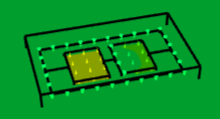
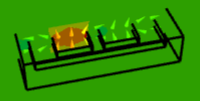

edge DOF =  13569
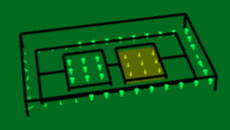
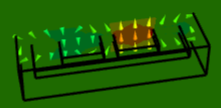

edge DOF =  1842
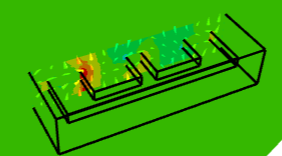

In [4]:
import math
jomega=False
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=True
feOrder=1
mu=4e-7*math.pi
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_air_region=model.total_air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

In [5]:
fesT = HCurl(mesh, order=feOrder, nograds=True, definedon=conductive_region,
                     dirichlet=conductor_boundary, complex=jomega)
if Dirichlet==True:
    fesOmega=H1(mesh, order=feOrder, dirichlet=reduced_boundary, complex=jomega)
else:
    fesOmega=H1(mesh, order=feOrder, complex=jomega)
    
fesTOmega=fesT*fesOmega
(T,omega),(W,psi) = fesTOmega.TnT()




In [6]:
#field=model.coil.field
field=UNIF(0,0,0.01,0)
Bv=Bfield(field)
Hv=Bv/mu
Bs=model.ReducedField(Bv, (0,0,0))

a= BilinearForm(fesTOmega)
a +=Mu*grad(omega)*grad(psi)*dx(air_region)
a +=Mu*(T+grad(omega))*(W+grad(psi))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

In [7]:
gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega=gfTOmega.components
if Dirichlet==False:
    b=Bfield(field)
    f = LinearForm(fesTOmega)
    f += (normal*b)*psi*ds(reduced_boundary)
    with TaskManager():
        f.Assemble()
    #gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0., complex=jomega)

else:  
    O=Ofield(field)
    gfOmega.Set(O, BND, mesh.Boundaries(reduced_boundary))
    """
    r=-a.mat*gfTOmega.vec
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, r.Evaluate(), tol=1.e-16, max_iter=200, accel_factor=1.1, complex=jomega)

    """
    f = LinearForm(fesTOmega)
    f +=-Mu*grad(gfOmega)*grad(psi)*dx
    with TaskManager():
        f.Assemble()


In [8]:
loops=LoopFields(model)
g=len(loops)
for k in range(g):
    Draw(loops[k], mesh)

Surface face count=  654
Surface edge count=  981
Surface node count=  327
genus=  1
edge DOF =  1261
enter iccg_solve
Dof= 2366    matrix size= 10561.0
shift parameter= 1.0
minimum residual= 9.527926534338955e-16  at iteraions:  37
結果のノルム: 9.197766901889079e-10
power=  426.5480860951686
enter iccg_solve
Dof= 362    matrix size= 849.0
shift parameter= 1.0
minimum residual= 2.477602500929872e-17  at iteraions:  17
結果のノルム: 1.4791734528730818e-16
power=  0.01469428091234272
k= 0    norm2= 4.6319282129183916e-08


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

fv= [<ngsolve.comp.LinearForm object at 0x000001F4DA739AB0>]
fafv [[8.108051168593865e-06]]
dim= 1364   nadd= 1
size of matrix=  22366
shift parameter= 1.0
minimum residual= 8.778173333674423e-17  at iteraions:  39


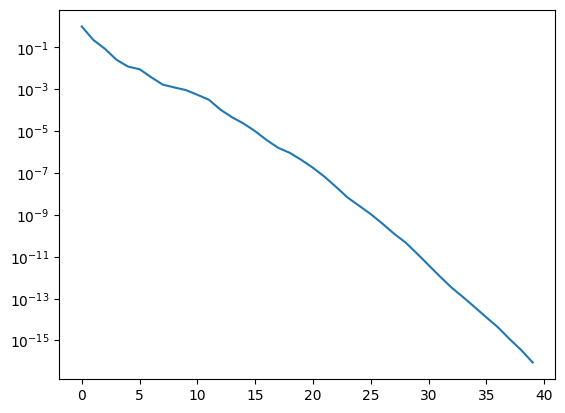

結果のノルム: 8.85478524505967e-16


In [9]:
if g !=0 : 
    fv, fafv=loopFieldCouplings(loops, s, model, fesTOmega)
    print("fv=", fv)
    print("fafv", fafv)
    
    fg=[]
    for n in range(g): fg.append(0)
    sol, amp =solver.SolveCoupled2(fesTOmega, a, fv, fafv, f.vec.FV(), fg,
                     tol=1.e-16, max_iter=200, accel_factor=0, logplot=True, complex=jomega)

    for n in range(g):
        if n==0:
            loopsum= amp[0]*loops[0]
        else:
            loopsum +=amp[n]*loops[n]
    gfT.Set(loopsum, BND, mesh.Boundaries(conductor_boundary))
    np.array(gfTOmega.vec.FV(), copy=False)[fesTOmega.FreeDofs()] +=sol

    Bfield=Mu*(gfT+grad(gfOmega))
    Bfield +=Mu*loopsum


else:
    gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, plotlog=False, complex=jomega)   
    Bfield=Mu*(gfT+grad(gfOmega))
    
Jfield=curl(gfT)

In [10]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  1.09849978815134


In [11]:
from ngsolve import *
from ngsolve.webgui import Draw
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

feOrder=3
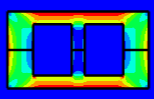
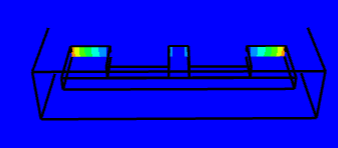

Average Joule loss=  1.1699962292455188

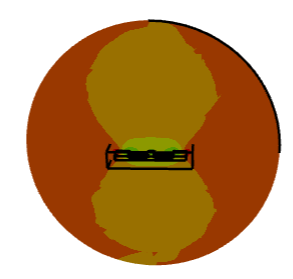
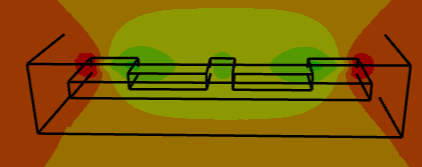